In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Social Network Analysis

## 4. Equivalence Based Role Mining

Task: Grouping users into equivalence classes that define roles
Reference: Doran, D. (2017). Network Role Mining and Analysis. Springer International Publishing, Chapter 3.

In [1]:
# %pip install networkx[default]

In [2]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## The Data

The data set is provided by Der Standard, one of the top Austrian newspapers.
In the online Standard people can post comments below articles and up/down vote comments.
The data set used in this handson and further in the project part of the course will consider a sample of those articles, comments, and votes. 

In [3]:
df1 = pd.read_csv('data/Postings_01052019_15052019.csv', sep=';')
df2 = pd.read_csv('data/Postings_16052019_31052019.csv', sep=';')
df = pd.concat([df1, df2], ignore_index=True)
df.head()

ID_Posting  ID_Posting_Parent  ID_CommunityIdentity  \
0  1041073586       1.041073e+09                671476   
1  1041073839       1.041073e+09                566938   
2  1041073872       1.041069e+09                669286   
3  1041080734       1.041080e+09                671476   
4  1041080828                NaN                671476   

                                     PostingHeadline  \
0  Das hat gestern bereits der Voggenhuber angefü...   
1                                                NaN   
2                                                NaN   
3                  Sie haben doch nichts gefordert??   
4  Heute wäre der perfekte Tag für die SPÖ gewese...   

                                      PostingComment         PostingCreatedAt  \
0  schieder hatte dem inhaltlich nichts entgegenz...  2019-05-01 18:21:15.127   
1     ...und meinen Bezirk bekommst du als Erbe mit.  2019-05-01 18:28:22.040   
2  Nein, bei der ÖVP/FPÖ genauso passiert. Ich wo...  2019-05-01 18:29:05.533   
3  sie haben nur die regierung kritisiert. das di...  2019-05-01 22:37:56.010   
4  ihr noch nicht erfülltes versprechen, den silb...  2019-05-01 22:42:06.310   

      ID_Article   ArticlePublishingDate  \
0  2000102330973  2019-05-01 10:28:57.49   
1  2000102330973  2019-05-01 10:28:57.49   
2  2000102330973  2019-05-01 10:28:57.49   
3  2000102330973  2019-05-01 10:28:57.49   
4  2000102330973  2019-05-01 10:28:57.49   

                                        ArticleTitle ArticleChannel  \
0  1. Mai in Wien: SPÖ fordert von Strache Rücktritt         Inland   
1  1. Mai in Wien: SPÖ fordert von Strache Rücktritt         Inland   
2  1. Mai in Wien: SPÖ fordert von Strache Rücktritt         Inland   
3  1. Mai in Wien: SPÖ fordert von Strache Rücktritt         Inland   
4  1. Mai in Wien: SPÖ fordert von Strache Rücktritt         Inland   

  ArticleRessortName UserCommunityName UserGender            UserCreatedAt  
0           Parteien       Ravenspower        NaN  2018-04-14 13:42:28.470  
1           Parteien        AlphaRomeo          m  2015-08-28 17:07:41.110  
2           Parteien        Hpolditsch        NaN  2018-03-06 20:03:42.737  
3           Parteien       Ravenspower        NaN  2018-04-14 13:42:28.470  
4           Parteien       Ravenspower        NaN  2018-04-14 13:42:28.470

There are different entities in the data set: 
* Users - identified by *ID_CommunityIdentity* (or *UserCommunityName*)
* Postings - identified by *ID_Posting*
* Articles - identified by *ID_Article*

Thus, there are different possibilities to build networks based on the posting data. 
We will concentrate now on the ***reply-to-network***. 


In [4]:
votes1 = pd.read_csv('./data/Votes_01052019_15052019.csv', sep=';')
votes2 = pd.read_csv('./data/Votes_16052019_31052019.csv', sep=';')
votes = pd.concat([votes1, votes2], ignore_index=True)
votes.head()

ID_CommunityIdentity  ID_Posting  VoteNegative  VotePositive  \
0                675862  1041076570             1             0   
1                689023  1041076570             1             0   
2                 24810  1041076745             0             1   
3                673781  1041076745             0             1   
4                 24810  1041076831             0             1   

             VoteCreatedAt    UserCommunityName UserGender  \
0  2019-05-06 16:47:46.883  Heckscheibenwischer          m   
1  2019-05-01 22:19:06.240      Heinz Fettleber        NaN   
2  2019-05-01 23:54:54.600       Bruce Campbell          m   
3  2019-05-01 20:59:29.910         Erdäpfelsack        NaN   
4  2019-05-01 23:51:42.730       Bruce Campbell          m   

             UserCreatedAt  
0  2018-06-26 06:04:30.513  
1  2019-03-08 21:23:11.463  
2  2011-01-12 16:50:40.597  
3  2018-05-29 07:13:49.350  
4  2011-01-12 16:50:40.597

In [5]:
# votes_sample = votes[:1000]
# votes_sample.to_csv('./data/votes_sample.csv', sep=',')
# 
# df_sample = df[:1000]
# df_sample.to_csv('./data/df_sample.csv', sep=',')

In [6]:
votes['UserGender'].value_counts()

UserGender
m    2351994
w     599012
Name: count, dtype: int64

In [7]:
merged_data = pd.merge(df, votes, on='ID_Posting')

# Dropping any duplicate columns that might have been created due to the merge
merged_data = merged_data.loc[:,~merged_data.columns.duplicated()]
merged_data.head()

ID_Posting  ID_Posting_Parent  ID_CommunityIdentity_x  \
0  1041073586       1.041073e+09                  671476   
1  1041073586       1.041073e+09                  671476   
2  1041073586       1.041073e+09                  671476   
3  1041080734       1.041080e+09                  671476   
4  1041080734       1.041080e+09                  671476   

                                     PostingHeadline  \
0  Das hat gestern bereits der Voggenhuber angefü...   
1  Das hat gestern bereits der Voggenhuber angefü...   
2  Das hat gestern bereits der Voggenhuber angefü...   
3                  Sie haben doch nichts gefordert??   
4                  Sie haben doch nichts gefordert??   

                                      PostingComment         PostingCreatedAt  \
0  schieder hatte dem inhaltlich nichts entgegenz...  2019-05-01 18:21:15.127   
1  schieder hatte dem inhaltlich nichts entgegenz...  2019-05-01 18:21:15.127   
2  schieder hatte dem inhaltlich nichts entgegenz...  2019-05-01 18:21:15.127   
3  sie haben nur die regierung kritisiert. das di...  2019-05-01 22:37:56.010   
4  sie haben nur die regierung kritisiert. das di...  2019-05-01 22:37:56.010   

      ID_Article   ArticlePublishingDate  \
0  2000102330973  2019-05-01 10:28:57.49   
1  2000102330973  2019-05-01 10:28:57.49   
2  2000102330973  2019-05-01 10:28:57.49   
3  2000102330973  2019-05-01 10:28:57.49   
4  2000102330973  2019-05-01 10:28:57.49   

                                        ArticleTitle ArticleChannel  ...  \
0  1. Mai in Wien: SPÖ fordert von Strache Rücktritt         Inland  ...   
1  1. Mai in Wien: SPÖ fordert von Strache Rücktritt         Inland  ...   
2  1. Mai in Wien: SPÖ fordert von Strache Rücktritt         Inland  ...   
3  1. Mai in Wien: SPÖ fordert von Strache Rücktritt         Inland  ...   
4  1. Mai in Wien: SPÖ fordert von Strache Rücktritt         Inland  ...   

  UserCommunityName_x UserGender_x          UserCreatedAt_x  \
0         Ravenspower          NaN  2018-04-14 13:42:28.470   
1         Ravenspower          NaN  2018-04-14 13:42:28.470   
2         Ravenspower          NaN  2018-04-14 13:42:28.470   
3         Ravenspower          NaN  2018-04-14 13:42:28.470   
4         Ravenspower          NaN  2018-04-14 13:42:28.470   

  ID_CommunityIdentity_y  VoteNegative  VotePositive            VoteCreatedAt  \
0                 572203             0             1  2019-05-01 18:46:37.437   
1                 206222             0             1  2019-05-01 18:38:54.227   
2                 212488             0             1  2019-05-01 22:43:43.030   
3                 581206             0             1  2019-05-01 23:31:04.717   
4                  25580             0             1  2019-05-01 23:30:32.150   

  UserCommunityName_y UserGender_y          UserCreatedAt_y  
0         Hollerbusch            w  2015-11-15 22:08:58.497  
1          Talerkogel            m  2001-09-28 11:54:33.000  
2              Chucho            m  2011-02-15 16:39:55.250  
3    wertekonservativ            m  2016-05-03 01:26:10.280  
4               CEEIT            m  2006-04-30 20:57:45.160  

[5 rows x 21 columns]

In [8]:
# merged_data[:1000].to_csv('./data/merged_df.csv', sep=';')

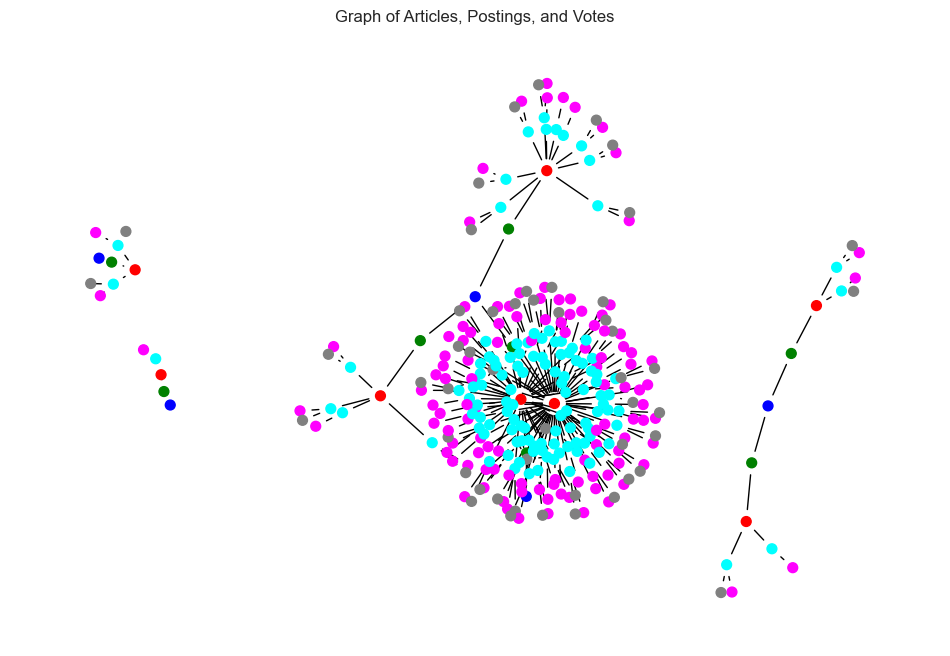

In [31]:
from utils.plots import plot_graph_with_weights
from utils.graphs import graph_article_posting_votes_nodes
from utils.graphs import graph_article_posting_weighted_votes
from utils.graphs import graph_article_posting_votes

# data = merged_data[merged_data['ID_Article'] == 2000102330973]
data = merged_data[:1000]
graph_data = data[['ArticleChannel', 'ArticleRessortName', 'ID_Article', 'ID_Posting', 'ID_Posting_Parent', 'VotePositive', 'VoteNegative']]


# G = graph_article_posting_votes_nodes(graph_data)
G = graph_article_posting_votes(graph_data)
# G = graph_
G = G.to_undirected()

plot_graph_with_weights(G)

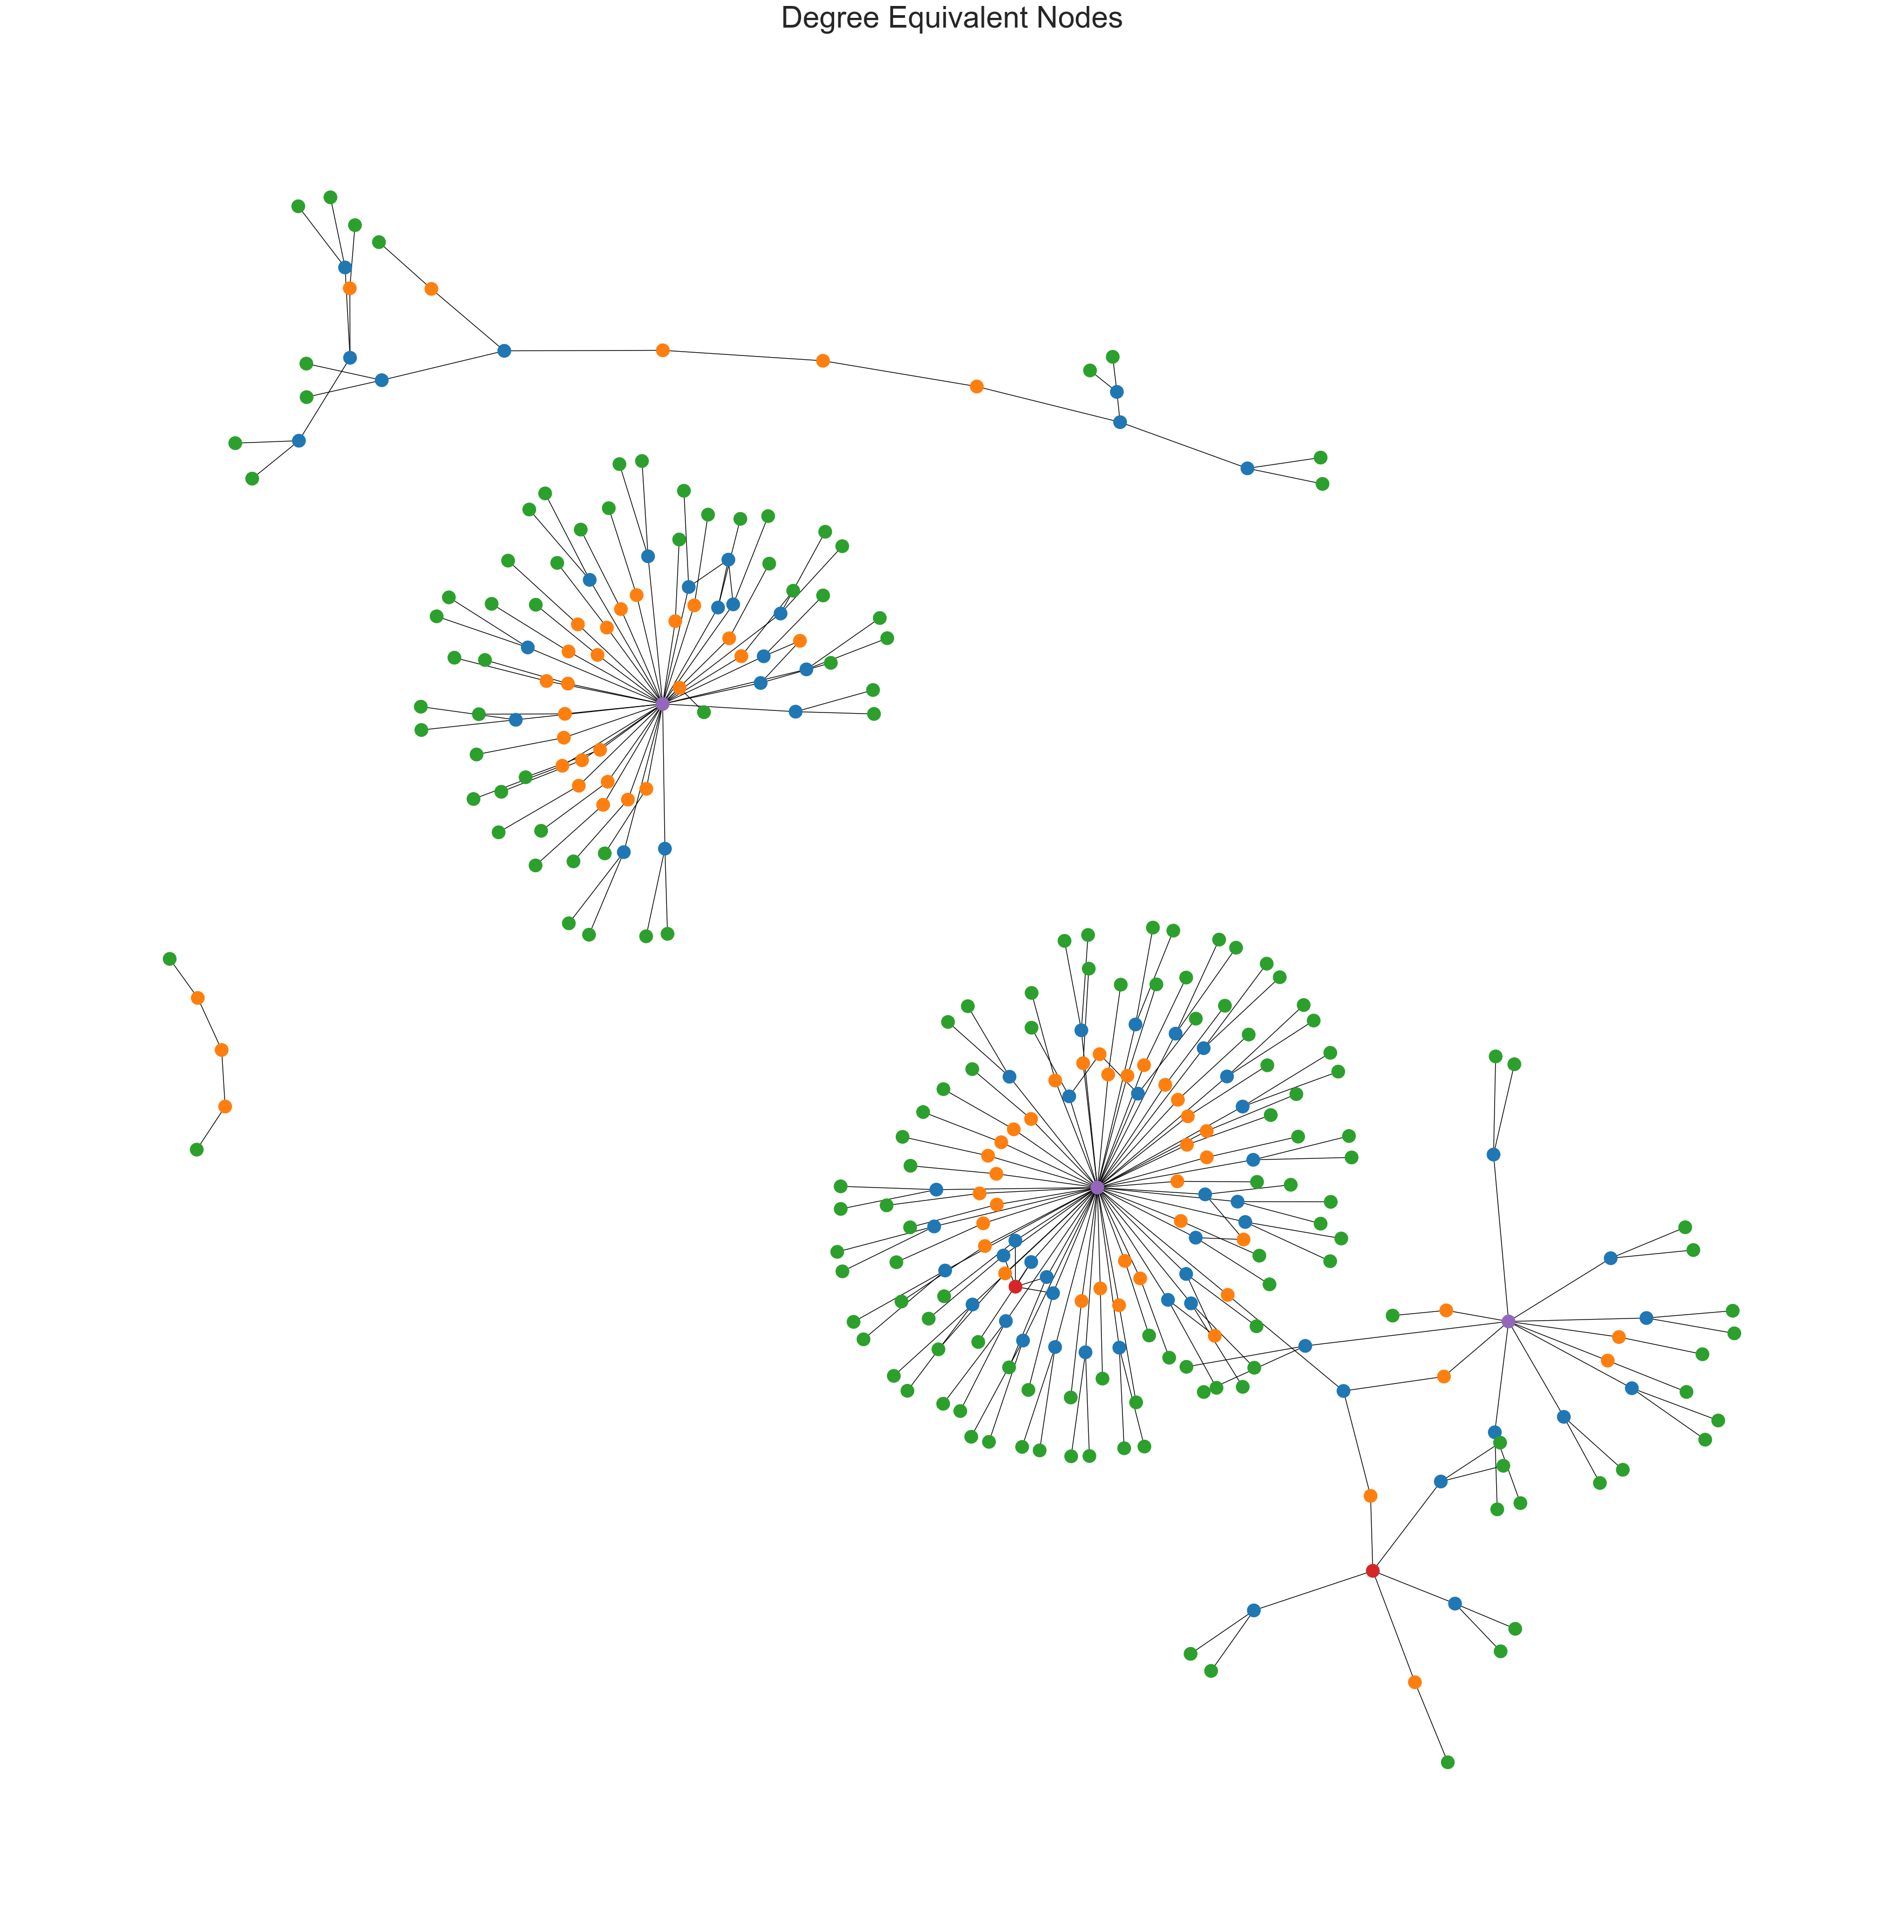

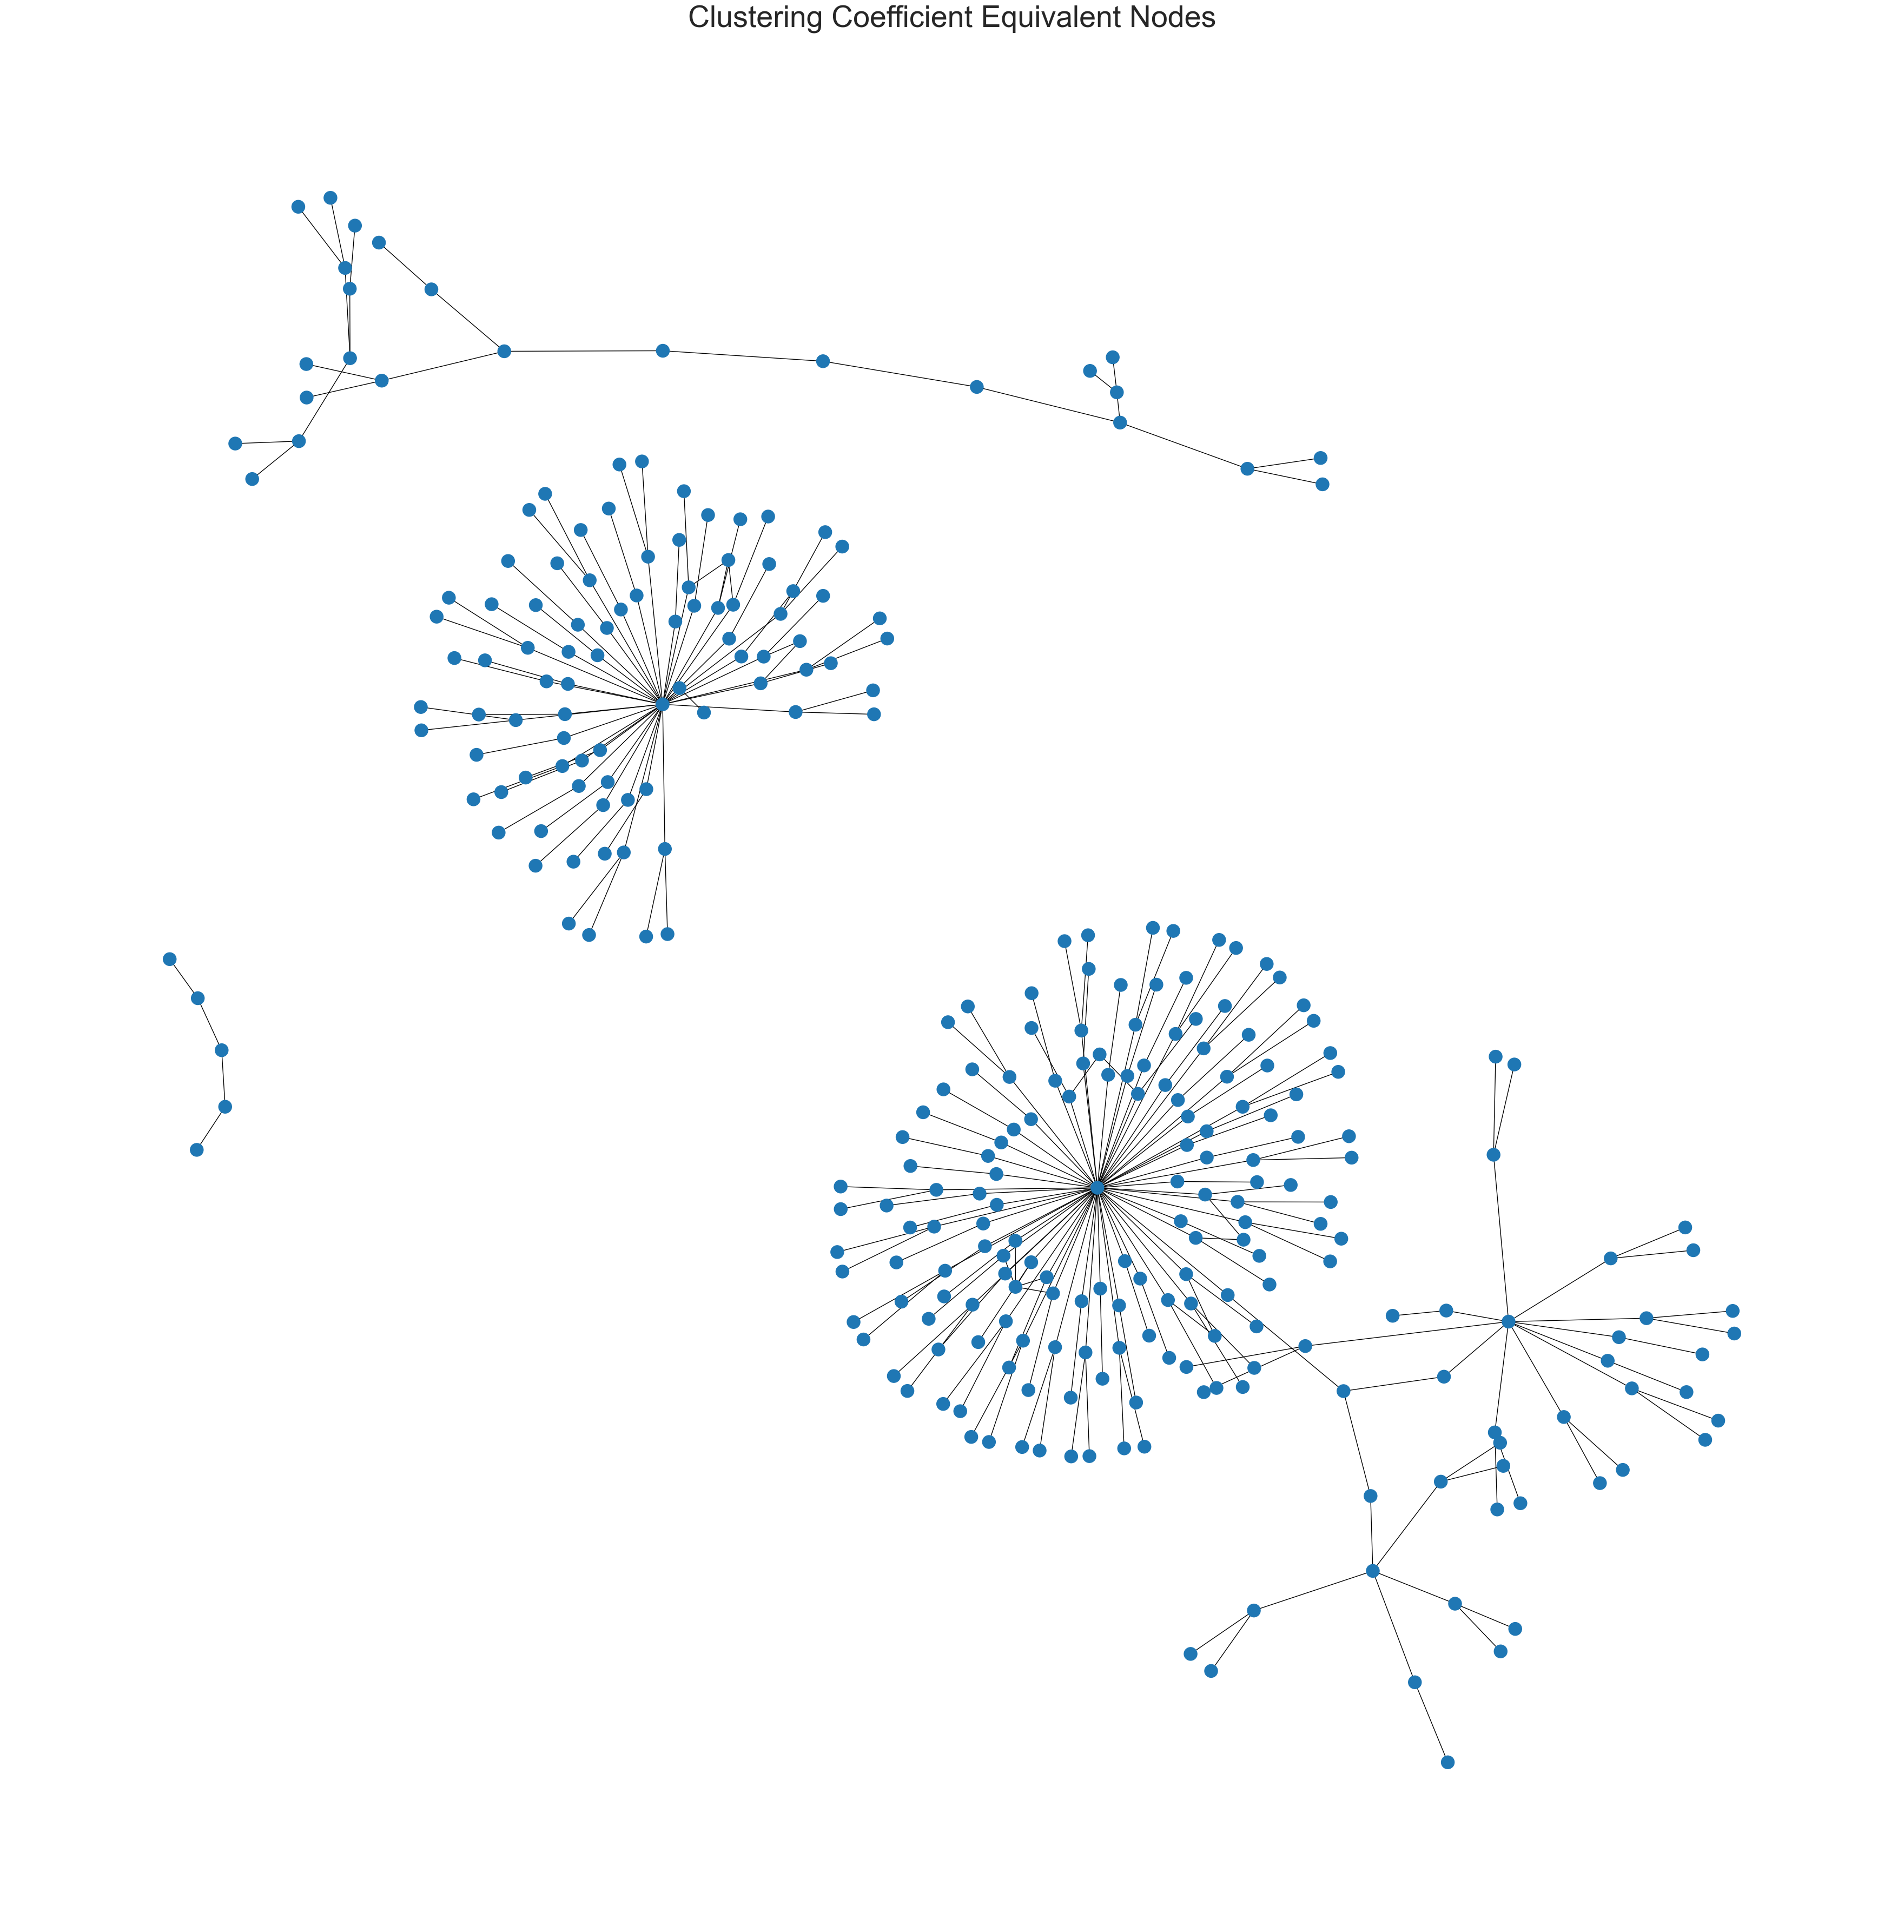

In [30]:
from utils.methods import equivalence_pipeline

equivalence_pipeline(G)

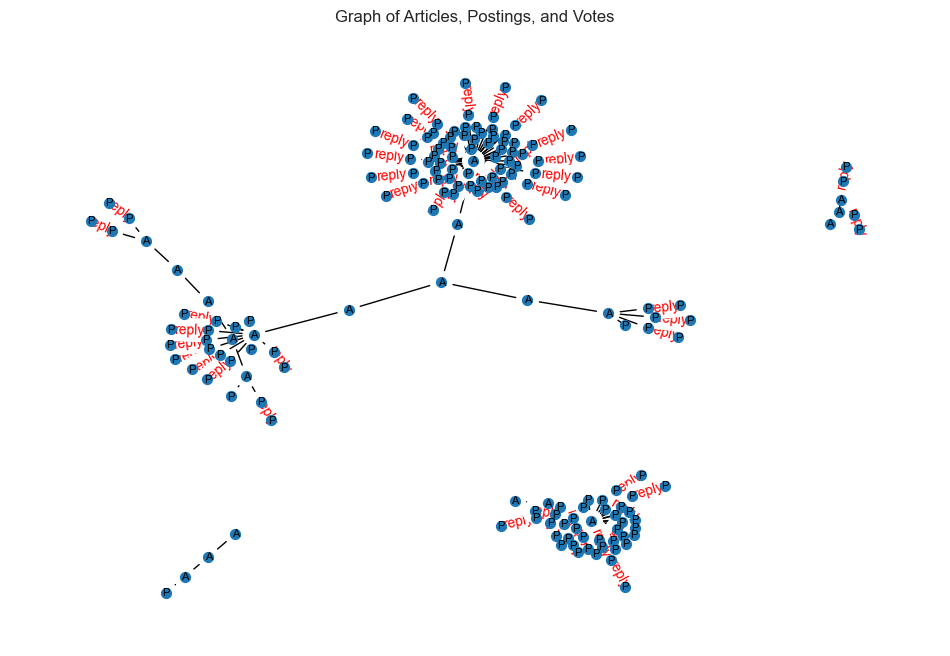

In [12]:
from utils.plots import plot_graph_with_weights
from utils.graphs import graph_article_posting_weighted_votes

G = graph_article_posting_weighted_votes(graph_data)
G = G.to_undirected()

plot_graph_with_weights(G)

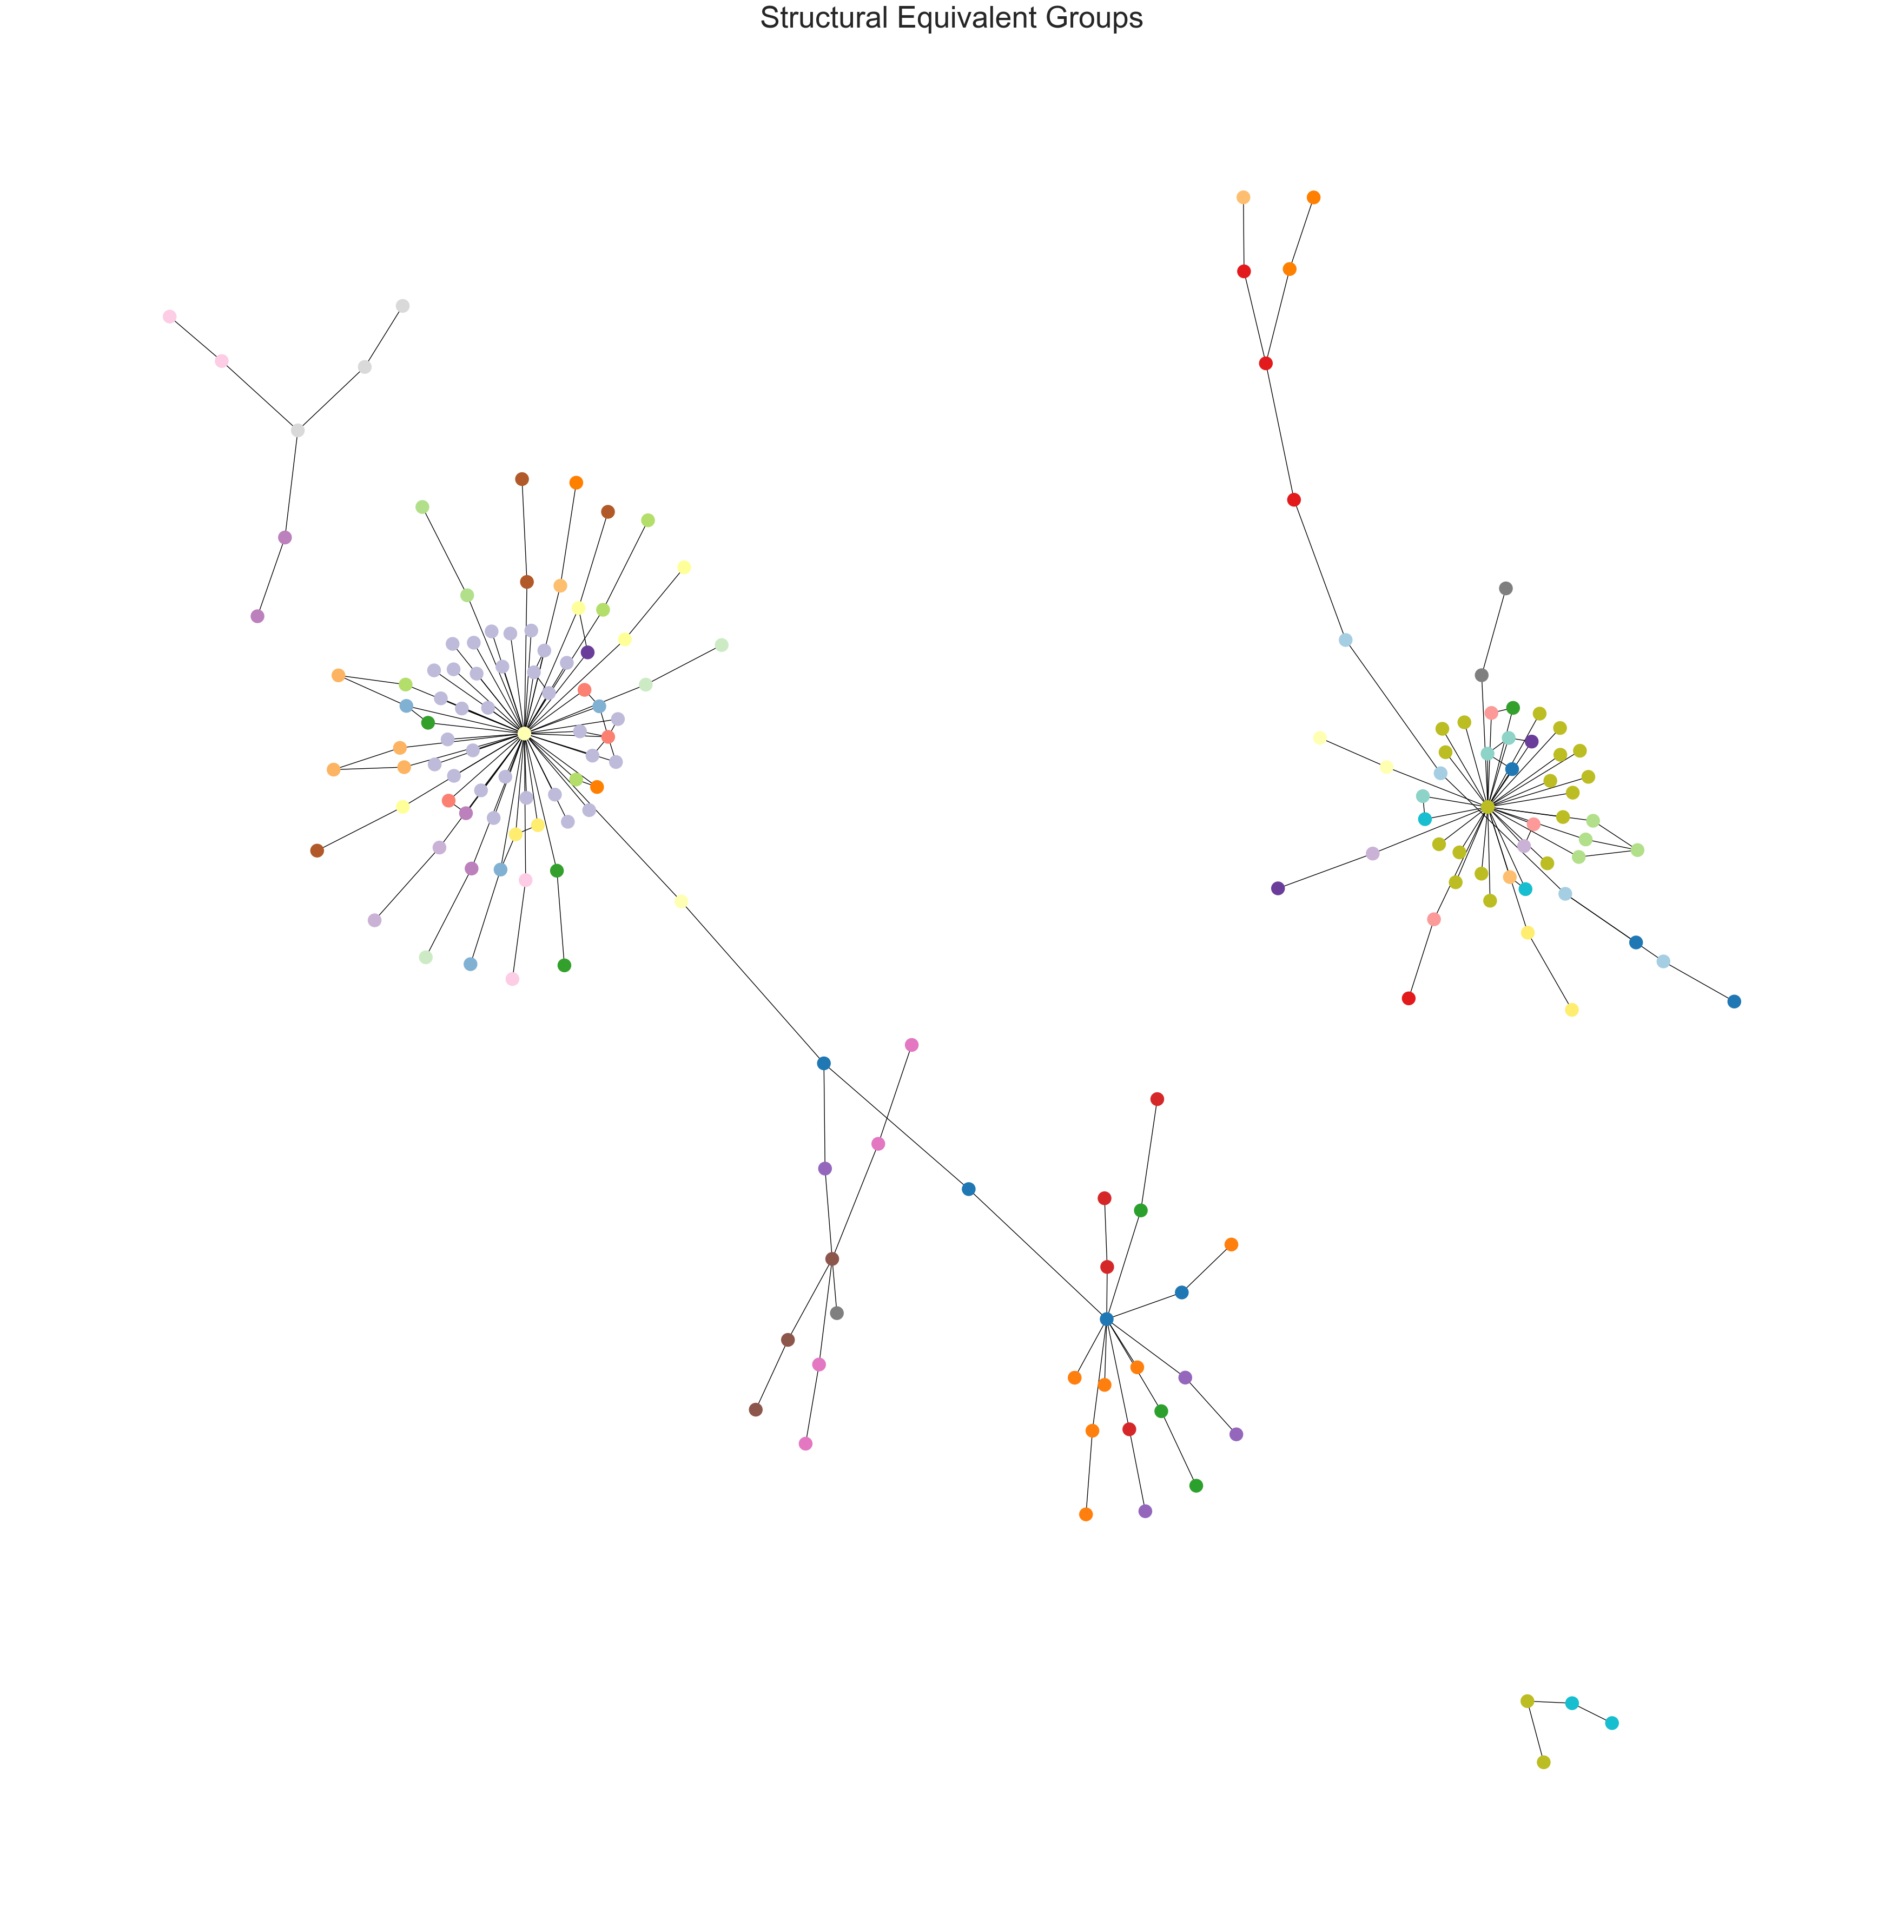

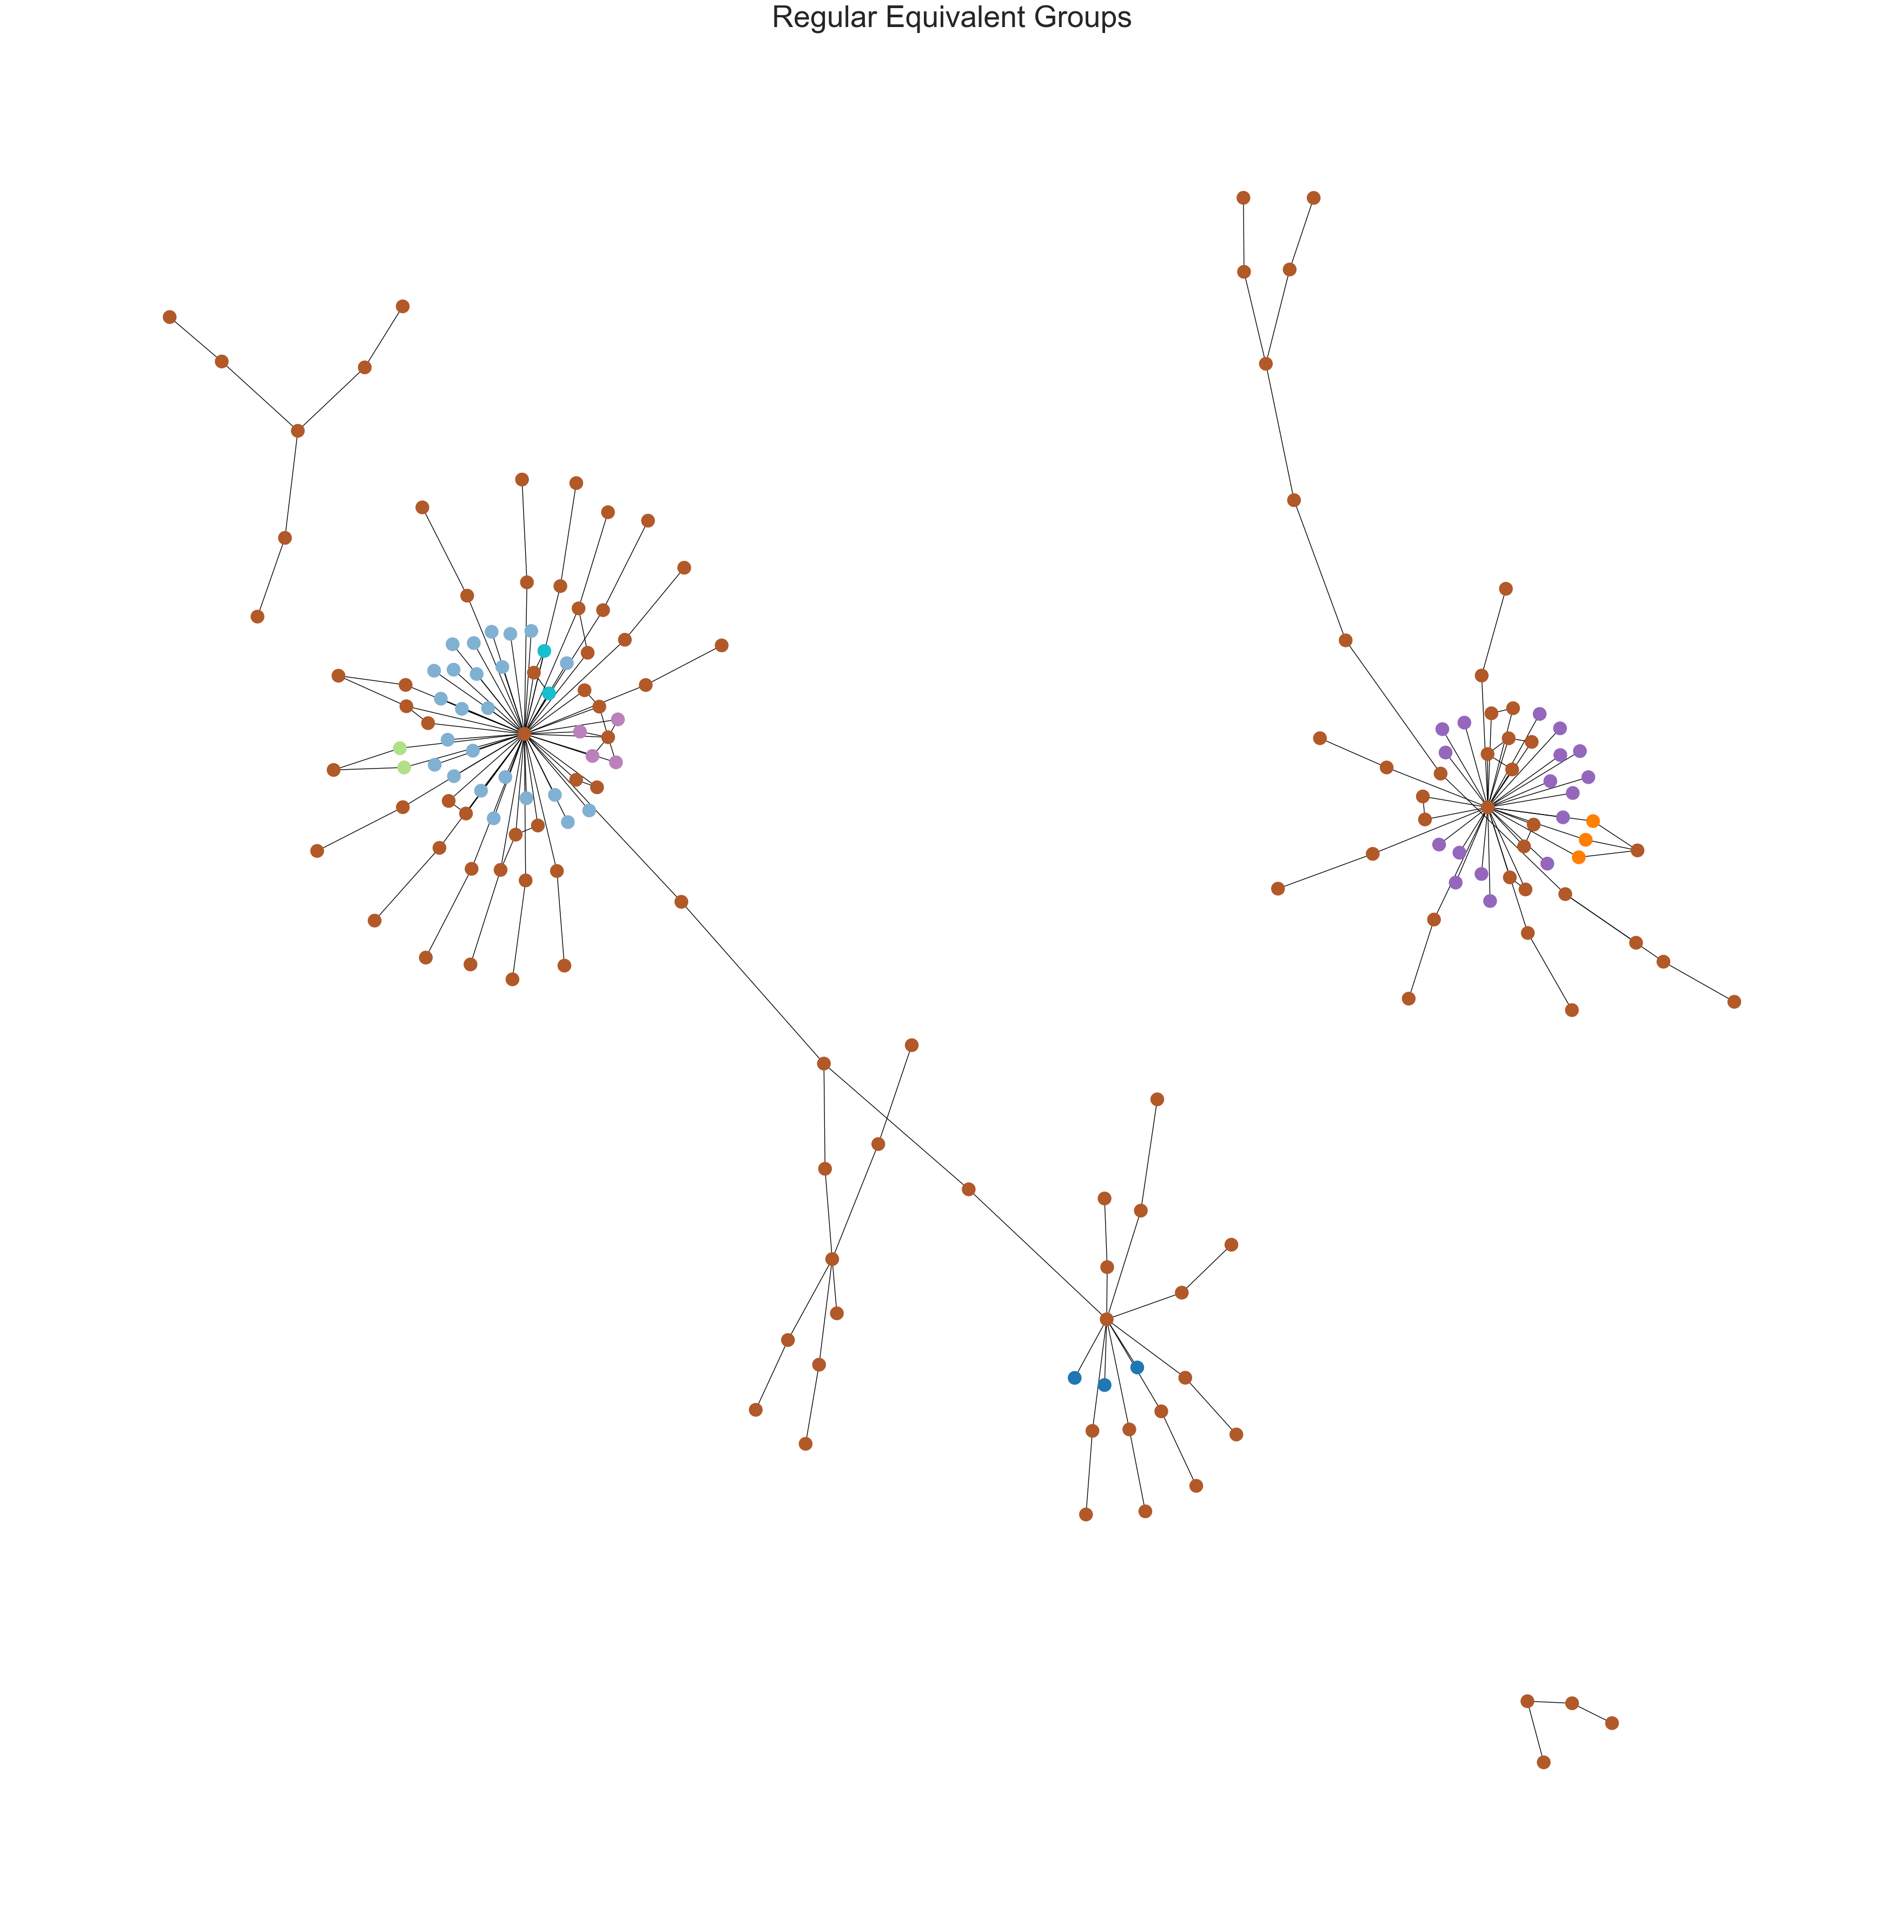

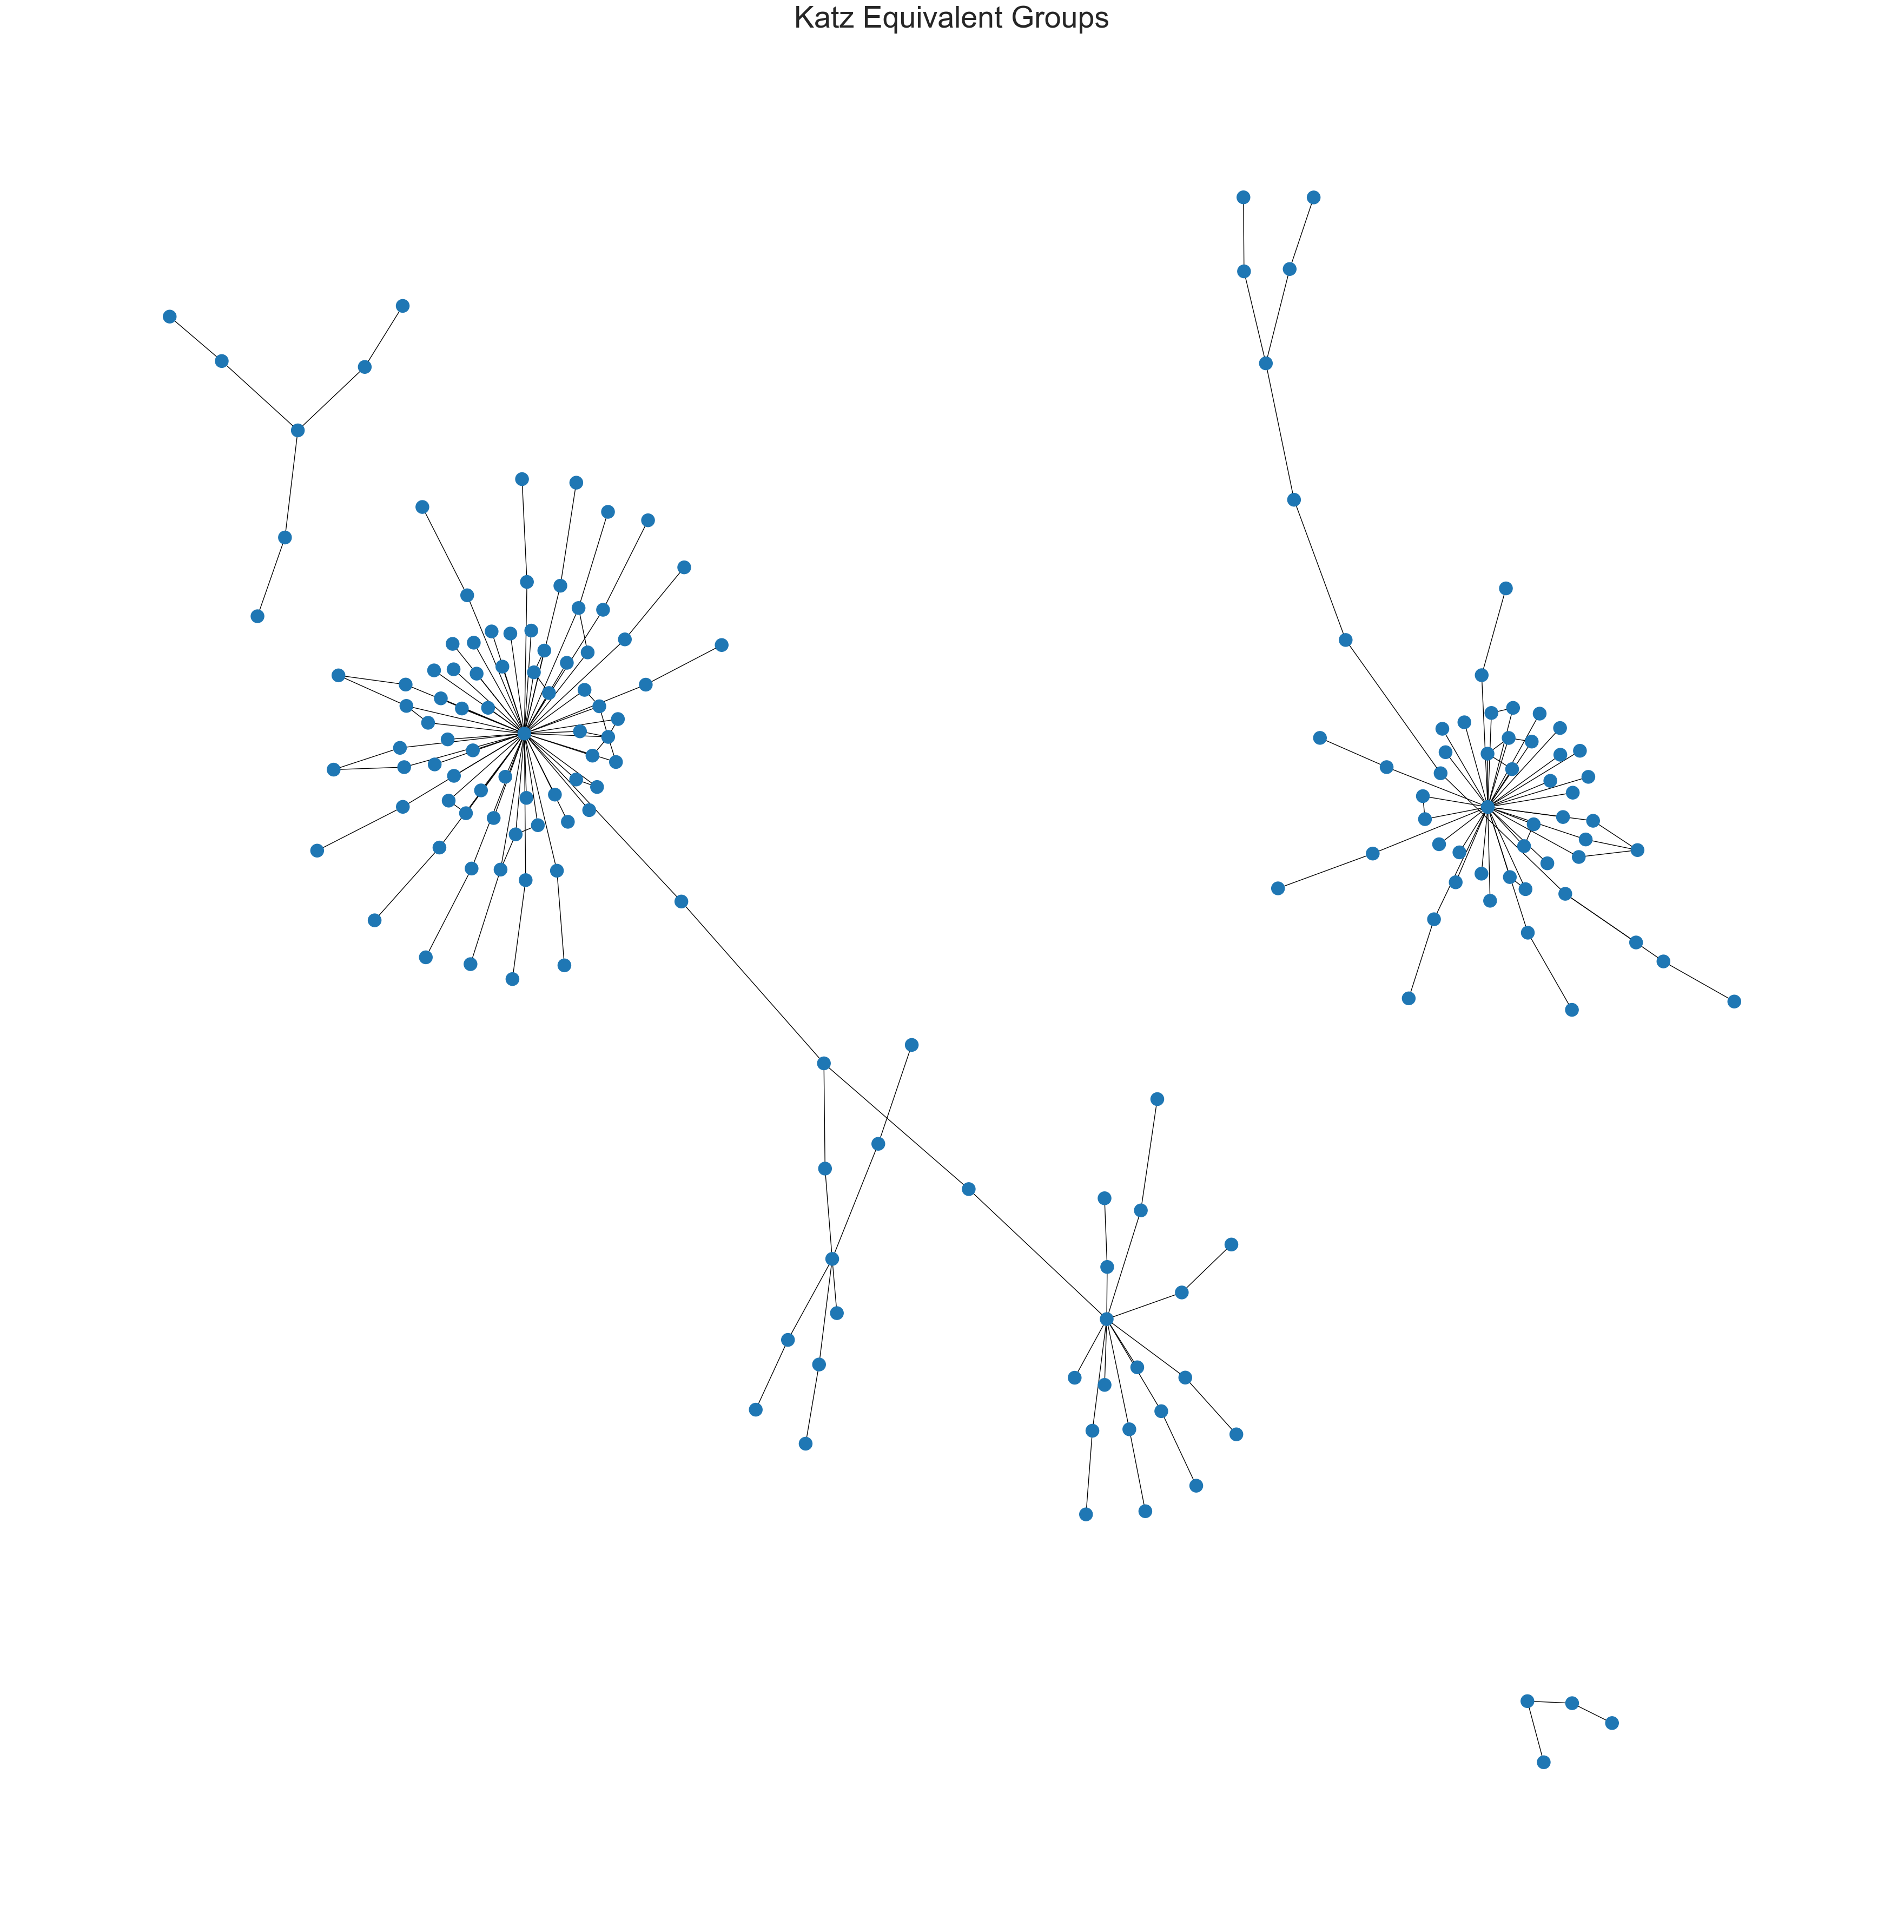

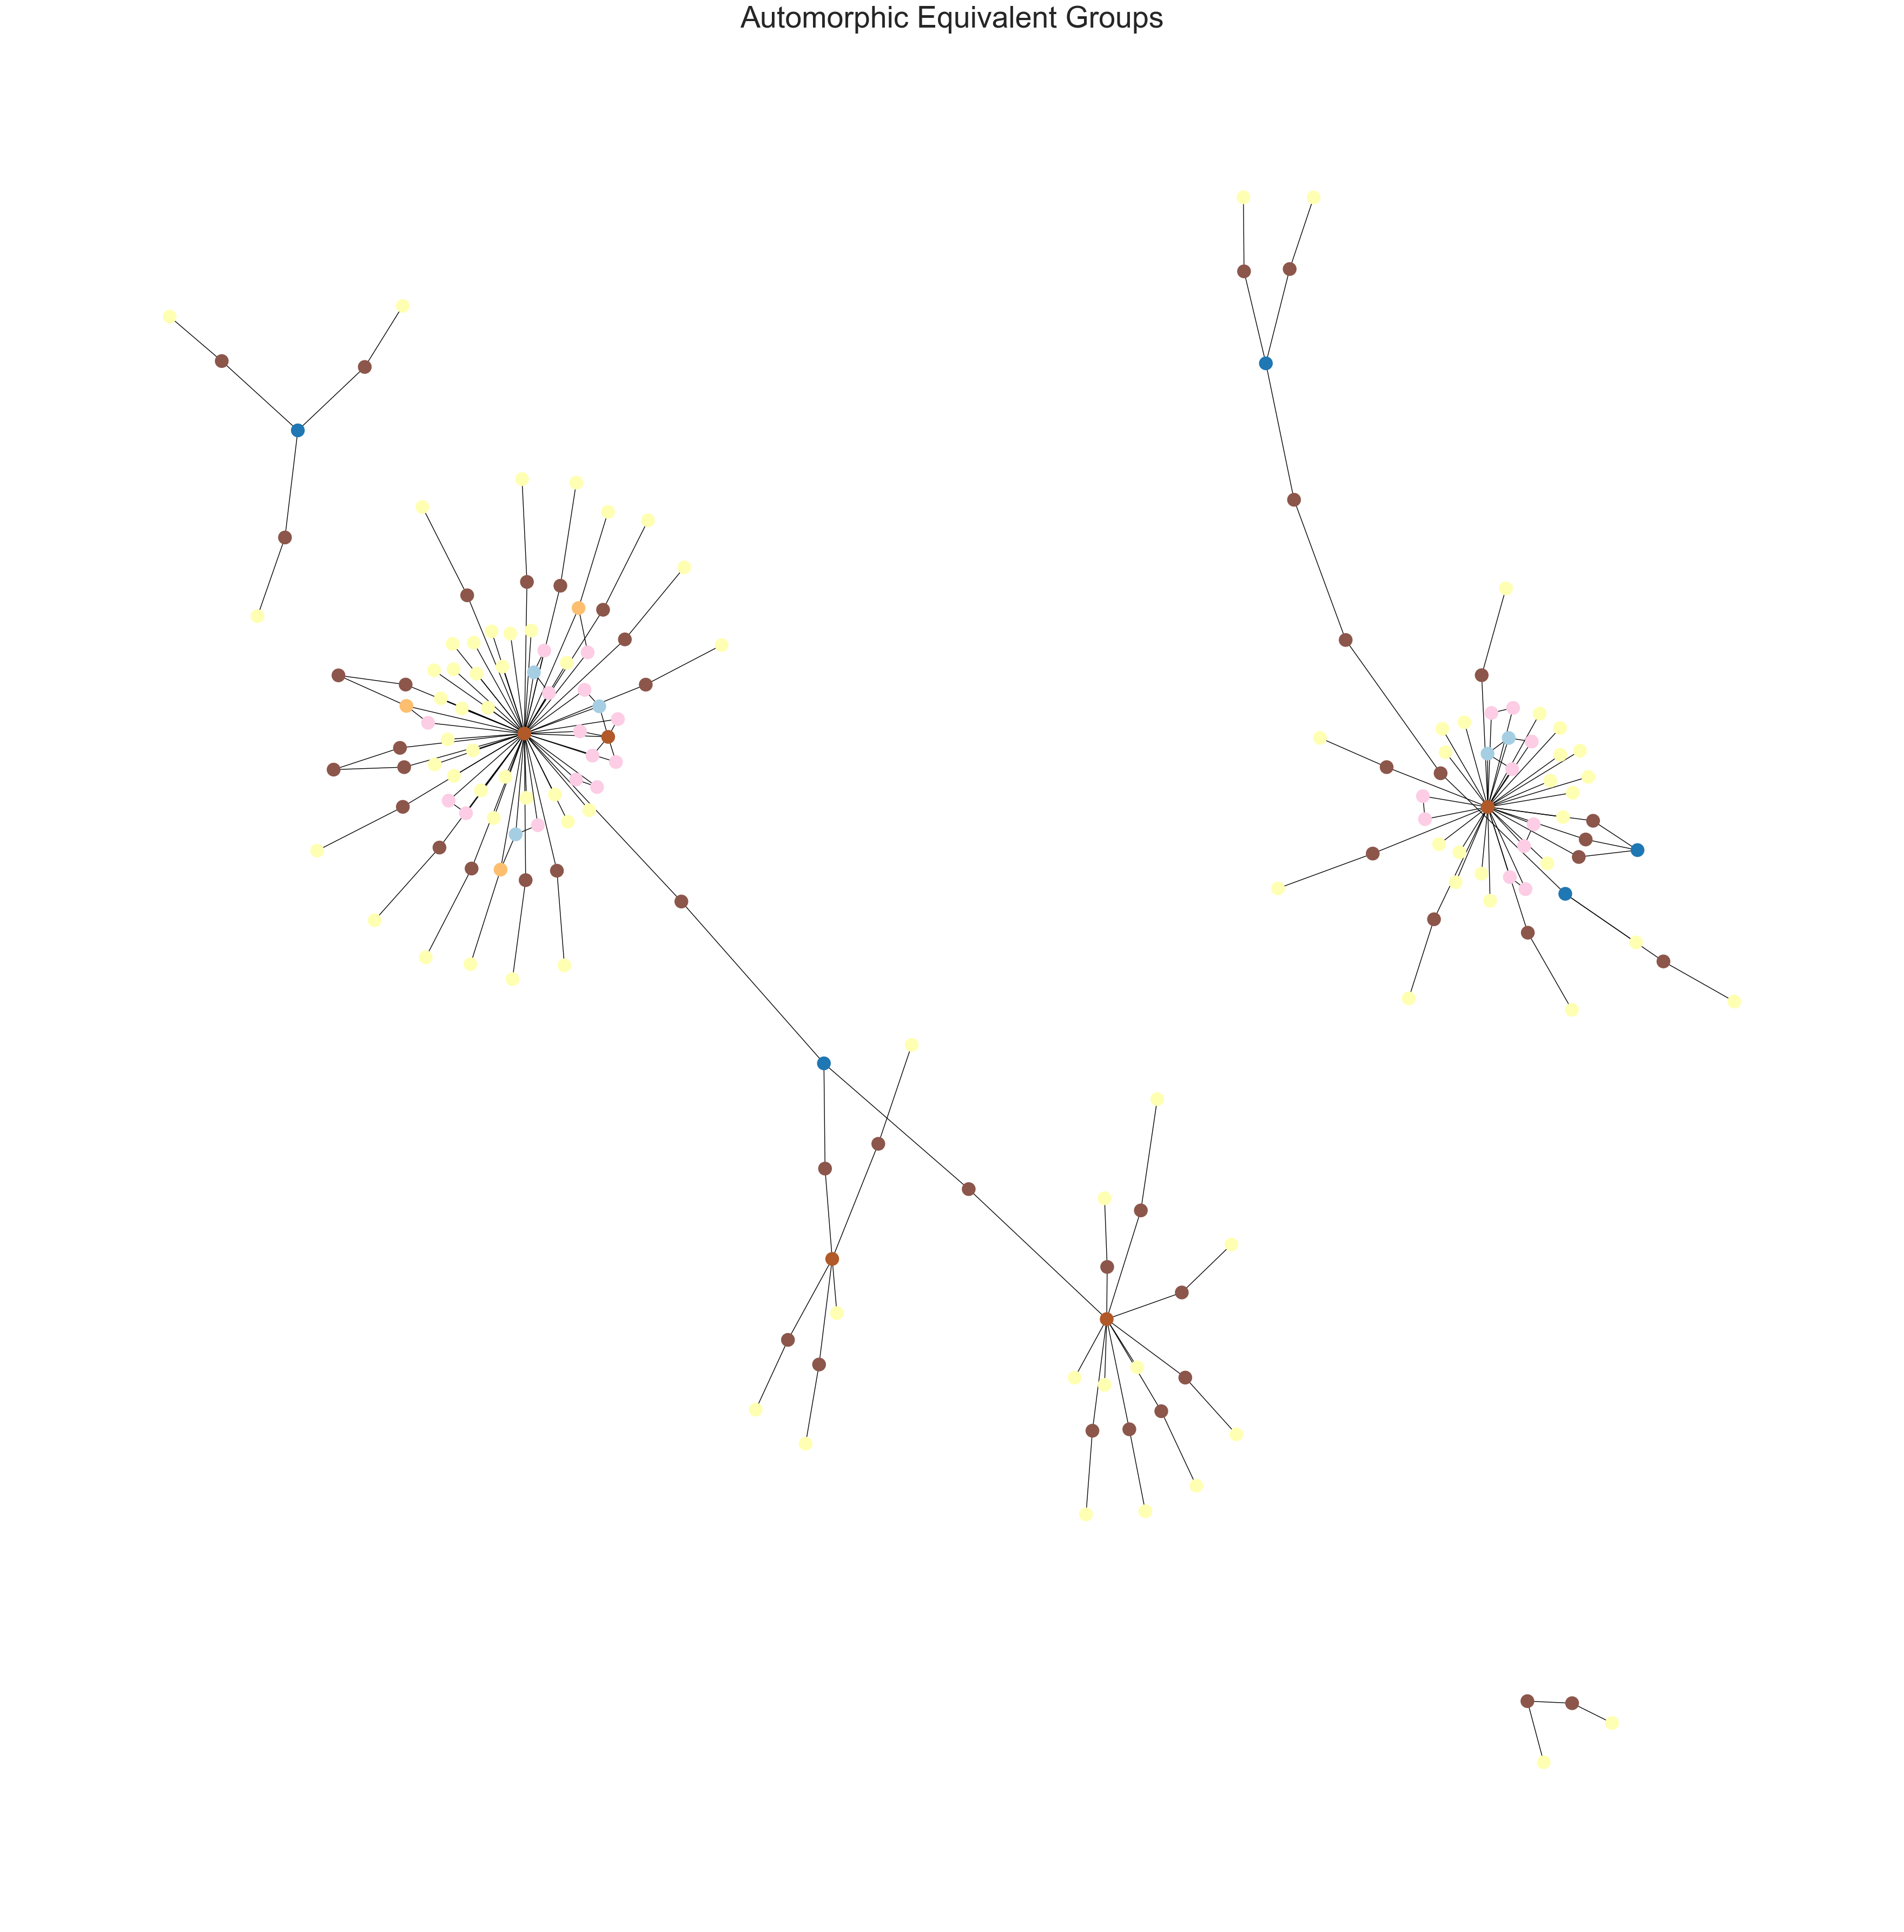

In [13]:
from utils.methods import equivalence_pipeline

equivalence_pipeline(G)

In [ ]:
from pyvis.network import Network

# Create an interactive network graph using pyvis
net = Network(notebook=True, directed=True, height="750px", width="100%")

# Add nodes to the network
for node, attr in G.nodes(data=True):
    node_str = str(node)  # Convert node identifier to string
    title = f"{attr['type']}: {node_str}"
    net.add_node(node_str, title=title, label=node_str, group=attr['type'])

# Add edges to the network, ensuring all nodes exist
for u, v, attr in G.edges(data=True):
    u_str, v_str = str(u), str(v)  # Convert edge node identifiers to strings
    if u_str in net.get_nodes() and v_str in net.get_nodes():
        label = attr.get('label', '')  # Use get method to avoid KeyError
        title = label if label else "Posted in response to" if u_str != v_str else "Posted in"
        net.add_edge(u_str, v_str, title=title, width=2 if label else 1)

# Set options for better visualization
net.set_options("""
{
  "nodes": {
    "font": {
      "size": 12
    }
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "smooth": false
  },
  "physics": {
    "enabled": false
  }
}
""")

net.save_graph("graph.html")
# net.show("graph.html")

## Community Detection

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns  # For color palette

G_undirected = G.to_undirected()

communities = nx.community.louvain_communities(G_undirected, seed=123)

colors = sns.color_palette("hsv", len(communities))

node_color_map = {}
for idx, community in enumerate(communities):
    for node in community:
        node_color_map[node] = colors[idx]

layout = nx.spring_layout(G_undirected, seed=42)

for node in G_undirected.nodes():
    nx.draw_networkx_nodes(G_undirected, layout, nodelist=[node],
                           node_size=20, node_color=[node_color_map[node]])

nx.draw_networkx_edges(G_undirected, layout, alpha=0.5)

plt.title("Graph with Communities Detected using Louvain Method")
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import itertools

def are_structurally_equivalent(G, node1, node2):
    """ Check if two nodes are structurally equivalent in the graph G. """
    return set(G.predecessors(node1)) == set(G.predecessors(node2)) and set(G.successors(node1)) == set(G.successors(node2))

def find_structural_equivalence_groups(G):
    """ Find groups of structurally equivalent nodes in the graph G. """
    equivalence_groups = []
    nodes_checked = set()

    for node1 in G:
        if node1 not in nodes_checked:
            current_group = {node1}
            nodes_checked.add(node1)
            for node2 in set(G) - nodes_checked:
                if are_structurally_equivalent(G, node1, node2):
                    current_group.add(node2)
                    nodes_checked.add(node2)
            equivalence_groups.append(current_group)

    return equivalence_groups

def plot_graph_with_equivalence(G):
    """ Plot the graph G with different colors for different structural equivalence groups. """
    plt.figure(figsize=(30, 30))
    equivalence_groups = find_structural_equivalence_groups(G)
    color_map = plt.cm.get_cmap('hsv', len(equivalence_groups))

    # Assign colors to nodes based on their group
    node_colors = {}
    for idx, group in enumerate(equivalence_groups):
        for node in group:
            node_colors[node] = color_map(idx)

    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes
    for idx, group in enumerate(equivalence_groups):
        nx.draw_networkx_nodes(G, pos, nodelist=group, node_color=[color_map(idx)]*len(group))
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)

    plt.show()

# Example usage
plot_graph_with_equivalence(G.to_directed())

In [ ]:
from utils.graphs import graph_article_posting_votes
from utils.methods import equivalence_pipeline

data = merged_data[:1000]
graph_data = data[['ArticleChannel', 'ArticleRessortName', 'ID_Article', 'ID_Posting', 'ID_Posting_Parent', 'VotePositive', 'VoteNegative']]

G = graph_article_posting_votes(graph_data)
G = G.to_undirected()
equivalence_pipeline(G)